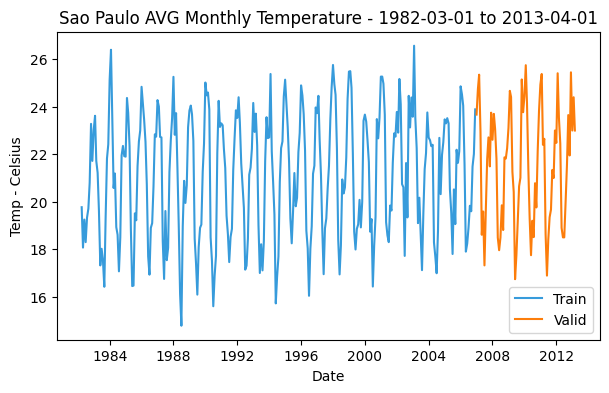

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
from sklearn import metrics

import pmdarima as pm
pd.plotting.register_matplotlib_converters()

# ---- Data Transformations ----
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
               'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

df = pd.read_csv('./Data/station_sao_paulo.csv')
df = df[['YEAR'] + list(months_dict.keys())]

df_sp = pd.melt(df, 
        id_vars='YEAR',
        value_vars=months_dict.keys(),
        var_name='MONTH', 
        value_name='Sum of Value').replace({"MONTH": months_dict})

df_sp['DAY'] = 1 #need a day for the pd.to_datetime() function
df_sp['DATE'] = pd.to_datetime(df_sp[['YEAR','MONTH','DAY']])
df_sp = df_sp[['DATE','Sum of Value']].rename(columns={'DATE':'date','Sum of Value':'temp'})
df_sp = df_sp.sort_values('date').reset_index(drop=True)

# ---- Visualize Data ----
# plt.figure(figsize=(7,4))
# plt.title("Sao Paulo AVG Monthly Temperature - w/ Err")
# plt.plot(df_sp["date"], df_sp['temp'], color='#379BDB', label='Original')
# plt.show(block=False)

df_sp = df_sp[(df_sp['date'] > '1982-03-01') & (df_sp['date'] < '2013-04-01')]
df_sp = df_sp.set_index(df_sp['date'], drop=True).drop(columns=["date"])

train, valid = df_sp[:int(len(df_sp)*0.8)], df_sp[int(len(df_sp)*0.8):]

plt.figure(figsize=(7,4))
plt.title("Sao Paulo AVG Monthly Temperature - 1982-03-01 to 2013-04-01")
plt.plot(train.index, train['temp'], color='#379BDB', label='Train')
plt.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
plt.xlabel('Date')
plt.ylabel('Temp - Celsius')
plt.legend()
plt.show(block=False)

In [2]:
SARIMA_model = pm.auto_arima(train['temp'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #annual frequency(12 for month, 7 for week etc) 
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [5]:
sarima_preds = []
df_sp.index = df_sp.index.to_period('M') 

for i in range(len(valid)):
    m_sarima = ARIMA(df_sp[:len(train)+i]['temp'], order=(1,0,0), seasonal_order=(0, 1, 2, 12)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])

residuals = sorted([x - y for x, y in zip(sarima_preds, valid['temp'].values)])

# Method 1

In [ ]:
# sw_result = stats.shapiro(residuals)
# ad_result = normal_ad(np.array(residuals), axis=0)
# dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

# plt.figure(figsize=(14,7))
# res = stats.probplot(residuals, plot=plt)
# ax = plt.gca()
# ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
#             bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
# ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
#             bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
# ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
#             bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

# plt.show()

In [ ]:
# RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
# band_size = 1.96*RMSFE

# fig, ax = plt.subplots(figsize=(7,4))
# ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
# ax.scatter(valid.index, sarima_preds)
# ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='b', alpha=.1)
# ax.set_title("Predictions w/ 95% Confidence")
# ax.set_xlabel('Date')
# ax.set_ylabel('Temp - Celsius')
# plt.show()

# Method 2

In [64]:
crossval_count = 100
min_size = 250
max_random = len(df_sp) - (min_size)

crossval_resids = []

In [65]:
for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]
    
    m_sarima = ARIMA(df_sp[start:end]['temp'], order=(1,0,0), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False).fit()
    pred = m_sarima.forecast(1).values[0]
    crossval_resids.append(pred - df_sp[end:end+1]['temp'].values[0])
    
bsed_residuals = sorted(crossval_resids)

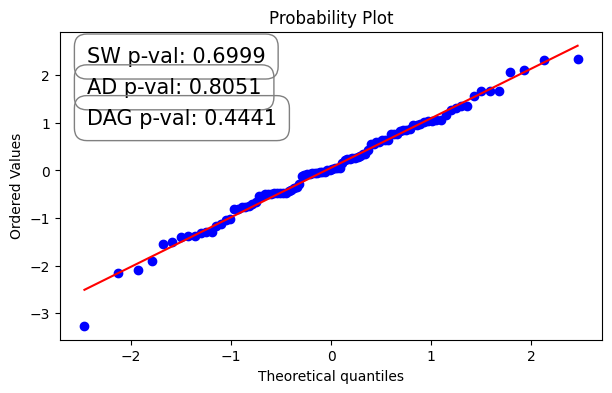

In [66]:
sw_result = stats.shapiro(bsed_residuals)
ad_result = normal_ad(np.array(bsed_residuals), axis=0)
dag_result = stats.normaltest(bsed_residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(7,4))
res = stats.probplot(bsed_residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

In [89]:
np.std([bsed_residuals[np.random.randint(len(bsed_residuals))] for x in range(len(bsed_residuals))])

1.091335728255792

In [90]:
bs_stds=[]
last_std = None

for i in range(10000):
    samples = [bsed_residuals[np.random.randint(len(bsed_residuals))] for x in range(len(bsed_residuals))]
    bs_stds.append(np.std(samples))
    if i%500 == 0 and i!=0:
        if i == 500:
            last_std = np.median(bs_stds)
        else:
            current_std = np.median(bs_stds)
            if abs(current_std - last_std) < last_std*0.00001:
                print("Early Stopping Iteration: {}".format(i))
                break
            else:
                last_std = np.median(bs_stds)        
    
bs_std = np.median(bs_stds)
print("Median of Bootstrapped STD's: {:.4f}".format(bs_std))

Early Stopping Iteration: 1500
Median of Bootstrapped STD's: 1.0134


In [93]:
valid['temp']

date
2007-01-01    23.67
2007-02-01    24.75
2007-03-01    25.35
2007-04-01    22.96
2007-05-01    18.61
              ...  
2012-11-01    21.95
2012-12-01    25.45
2013-01-01    23.00
2013-02-01    24.40
2013-03-01    23.00
Name: temp, Length: 75, dtype: float64

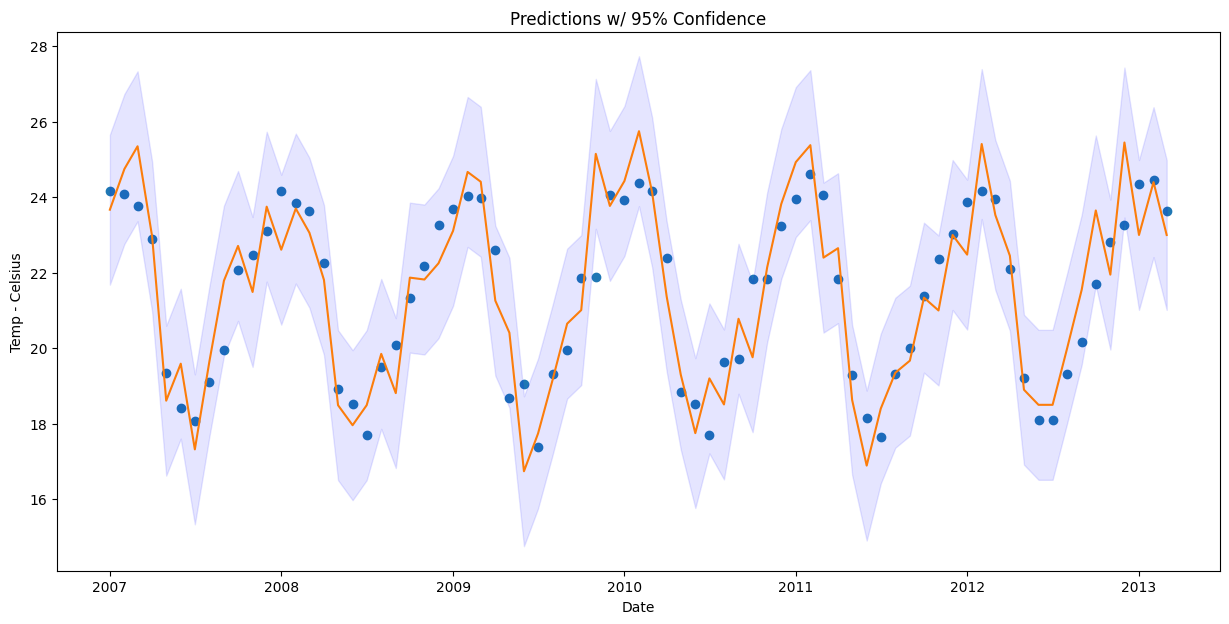

In [91]:
bs_band_size = 1.96*bs_std 

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['temp']-bs_band_size), (valid['temp']+bs_band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()